In [1]:
# This dataset analyzes the COVID-19 data for Colombia and builds the GeoJSON map counting active cases by department
# Author: Fabian Peña
# Creation date:
# Last modification date: 25/05/2020

In [2]:
import pandas as pd
import geopandas as gpd

from sodapy import Socrata

import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

%matplotlib inline

In [3]:
# Creating the Socrata client
client = Socrata( 'www.datos.gov.co', None )

In [4]:
# Loading the COVID-19 data for Colombia
results = client.get( 'gt2j-8ykr', limit = 100000 )
covid = pd.DataFrame.from_records(results)
covid.rename( columns = { 'id_de_caso': 'ID de caso',
                         'fecha_de_notificaci_n': 'Fecha de notificación',
                         'codigo_divipola': 'Codigo DIVIPOLA',
                         'ciudad_de_ubicaci_n': 'Ciudad de ubicación',
                         'departamento': 'Departamento o Distrito ',
                         'atenci_n': 'atención',
                         'edad': 'Edad',
                         'sexo': 'Sexo',
                         'tipo': 'Tipo',
                         'estado': 'Estado',
                         'pa_s_de_procedencia': 'País de procedencia',
                         'fis': 'FIS',
                         'fecha_de_muerte': 'Fecha de muerte',
                         'fecha_diagnostico': 'Fecha diagnostico',
                         'fecha_recuperado': 'Fecha recuperado',
                         'fecha_reporte_web': 'fecha reporte web' }, inplace = True )

In [5]:
# Getting the size of the df
covid.shape

(30493, 17)

In [6]:
# Add a new column for asimptomatic observations
covid.loc[ covid[ 'FIS' ] == 'Asintomático', 'Asintomático' ] = True
covid.loc[ covid[ 'FIS' ] != 'Asintomático', 'Asintomático' ] = False
covid[ 'Asintomático' ] = covid[ 'Asintomático' ].astype( bool )

In [7]:
# Casting date columns
covid[ 'Fecha de notificación' ] = pd.to_datetime( covid[ 'Fecha de notificación' ] )
covid[ 'FIS' ] = pd.to_datetime( covid[ 'FIS' ], errors = 'coerce' )
covid[ 'Fecha de muerte' ] = pd.to_datetime( covid[ 'Fecha de muerte' ], errors = 'coerce' )
covid[ 'Fecha diagnostico' ] = pd.to_datetime( covid[ 'Fecha diagnostico' ], errors = 'coerce' )
covid[ 'Fecha recuperado' ] = pd.to_datetime( covid[ 'Fecha recuperado' ], errors = 'coerce' )
covid[ 'fecha reporte web' ] = pd.to_datetime( covid[ 'fecha reporte web' ] )

In [8]:
# Unifying values for sex
covid[ 'Sexo' ].replace( { 'm': 'M', 'f': 'F' }, inplace = True )

In [9]:
# Unifying values for status
covid[ 'Estado' ].replace( { 'leve': 'Leve', 'LEVE': 'Leve' }, inplace = True )

In [10]:
# Unifying values for atention
covid[ 'atención' ].replace( { 'casa': 'Casa', 'N/A': None }, inplace = True )

In [11]:
# Unifying values for procedence
covid[ 'País de procedencia' ].replace( { '-   -': None }, inplace = True )

In [12]:
covid.loc[ covid[ 'Fecha recuperado' ].notnull(), 'Recuperado' ] = True
covid.loc[ covid[ 'Fecha recuperado' ].isnull(), 'Recuperado' ] = False

In [13]:
covid.loc[ covid[ 'Fecha de muerte' ].notnull(), 'Fallecido' ] = True
covid.loc[ covid[ 'Fecha de muerte' ].isnull(), 'Fallecido' ] = False

In [14]:
covid[ 'Edad' ] = covid[ 'Edad' ].astype( int )

In [15]:
# Getting the column types
covid.dtypes

ID de caso                          object
Fecha de notificación       datetime64[ns]
Codigo DIVIPOLA                     object
Ciudad de ubicación                 object
Departamento o Distrito             object
atención                            object
Edad                                 int64
Sexo                                object
Tipo                                object
Estado                              object
País de procedencia                 object
FIS                         datetime64[ns]
Fecha diagnostico           datetime64[ns]
Fecha recuperado            datetime64[ns]
fecha reporte web           datetime64[ns]
tipo_recuperaci_n                   object
Fecha de muerte             datetime64[ns]
Asintomático                          bool
Recuperado                            bool
Fallecido                             bool
dtype: object

In [16]:
# Showing the firts rows
covid.head()

,ID de caso,Fecha de notificación,Codigo DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha diagnostico,Fecha recuperado,fecha reporte web,tipo_recuperaci_n,Fecha de muerte,Asintomático,Recuperado,Fallecido
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,Italia,2020-02-27,2020-03-06,2020-03-13,2020-03-06,PCR,NaT,False,True,False
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,España,2020-03-04,2020-03-09,2020-03-19,2020-03-09,PCR,NaT,False,True,False
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,España,2020-02-29,2020-03-09,2020-03-15,2020-03-09,PCR,NaT,False,True,False
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,Colombia,2020-03-06,2020-03-11,2020-03-26,2020-03-11,PCR,NaT,False,True,False
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,Colombia,2020-03-08,2020-03-11,2020-03-23,2020-03-11,PCR,NaT,False,True,False


In [17]:
# How many observations have null atention
covid.loc[ covid[ 'atención' ].isnull() ].shape

(45, 20)

In [18]:
# How many observations have null status
covid.loc[ covid[ 'Estado' ].isnull() ].shape

(51, 20)

# Indicators

In [19]:
covid[ 'ID de caso' ].nunique()

30493

In [20]:
covid.loc[ covid[ 'Recuperado' ] == True ].shape[ 0 ]

9645

In [21]:
covid.loc[ covid[ 'Fallecido' ] == True ].shape[ 0 ]

1005

In [22]:
covid.loc[ ( covid[ 'atención' ] == 'Hospital' ) ].shape[ 0 ]

1443

In [23]:
covid.loc[ ( covid[ 'atención' ] == 'Hospital UCI' ) ].shape[ 0 ]

289

# Time series

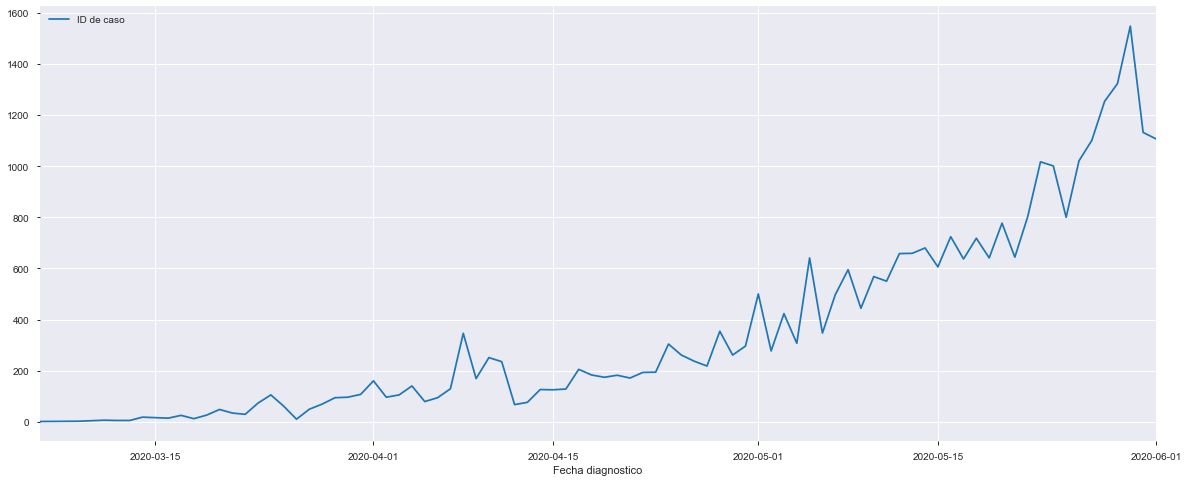

In [24]:
# Plotting diagnosed cases by day
covid.groupby( [ covid[ 'Fecha diagnostico' ].dt.date ] ).agg( { 'ID de caso': 'count' } ).plot( figsize = ( 20, 8 ) )

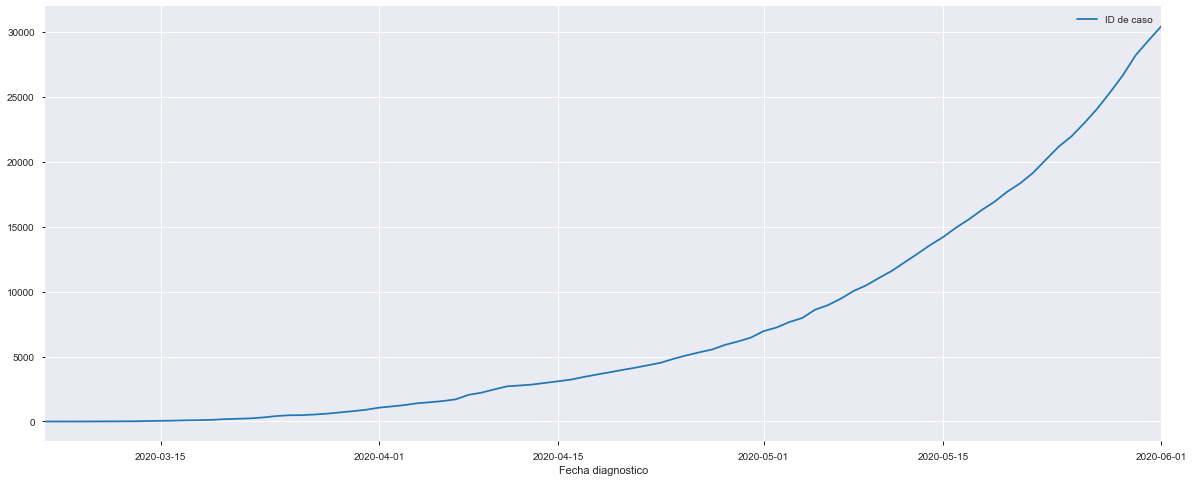

In [25]:
# Plotting diagnosed cases by day (cumulative sum)
covid.groupby( [ covid[ 'Fecha diagnostico' ].dt.date ] ).agg( { 'ID de caso': 'count' } ).cumsum().plot( figsize = ( 20, 8 ) )

In [26]:
# Preparing and merging the groupings in one dataframe

diagnosed = covid.groupby( [ covid[ 'Fecha diagnostico' ].dt.date ] ) \
    .agg( { 'ID de caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha diagnostico': 'Fecha', 'ID de caso': 'Diagnosticados' } )

recovered = covid.groupby( [ covid[ 'Fecha recuperado' ].dt.date ] )  \
    .agg( { 'ID de caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha recuperado': 'Fecha', 'ID de caso': 'Recuperados' } )

deaths = covid.groupby( [ covid[ 'Fecha de muerte' ].dt.date ] )  \
    .agg( { 'ID de caso': 'count' } ) \
    .cumsum() \
    .rename( columns = { 'Fecha de muerte': 'Fecha', 'ID de caso': 'Fallecidos' } )

infections = diagnosed.merge( recovered, how = 'outer', left_index = True, right_index = True )
infections = infections.merge( deaths, how = 'outer', left_index = True, right_index = True )
infections.fillna( 0, inplace = True )

In [27]:
infections.tail()

,Diagnosticados,Recuperados,Fallecidos
2020-05-28,25353,7614.0,949.0
2020-05-29,26676,7700.0,972.0
2020-05-30,28224,7718.0,994.0
2020-05-31,29356,9645.0,1005.0
2020-06-01,30463,0.0,0.0


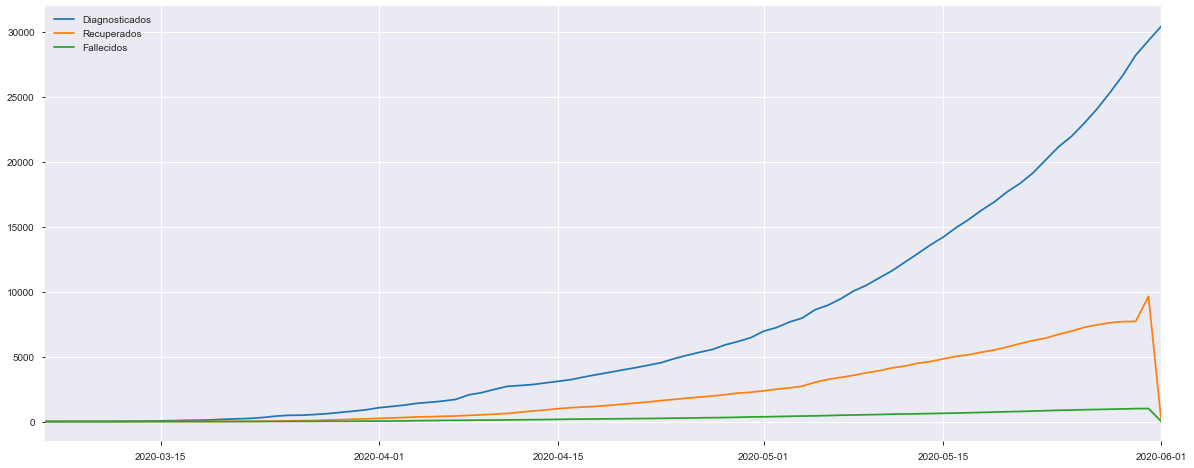

In [28]:
# Plotting diagnosed and recovered cases by day
infections.plot( figsize = ( 20, 8 ) )

In [29]:
# Calculating the difference between diagnosed and recovered cases
infections[ 'Casos activos' ] = infections[ 'Diagnosticados' ] - infections[ 'Recuperados' ]

In [30]:
infections.tail()

,Diagnosticados,Recuperados,Fallecidos,Casos activos
2020-05-28,25353,7614.0,949.0,17739.0
2020-05-29,26676,7700.0,972.0,18976.0
2020-05-30,28224,7718.0,994.0,20506.0
2020-05-31,29356,9645.0,1005.0,19711.0
2020-06-01,30463,0.0,0.0,30463.0


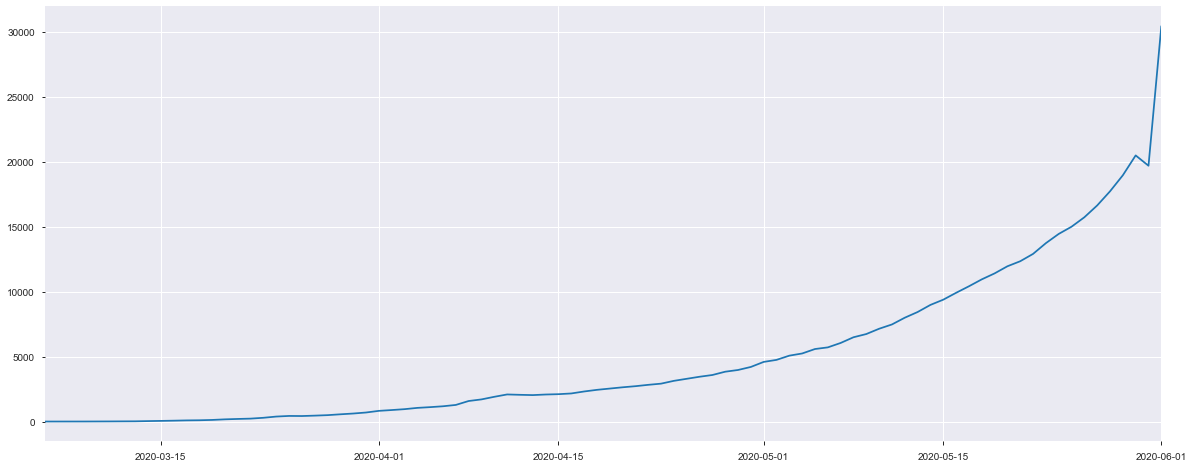

In [31]:
# Plotting difference cases by day
infections[ 'Casos activos' ].plot( figsize = ( 20, 8 ) )

# Geo

In [32]:
covid.head()

,ID de caso,Fecha de notificación,Codigo DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,País de procedencia,FIS,Fecha diagnostico,Fecha recuperado,fecha reporte web,tipo_recuperaci_n,Fecha de muerte,Asintomático,Recuperado,Fallecido
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,Italia,2020-02-27,2020-03-06,2020-03-13,2020-03-06,PCR,NaT,False,True,False
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,España,2020-03-04,2020-03-09,2020-03-19,2020-03-09,PCR,NaT,False,True,False
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,España,2020-02-29,2020-03-09,2020-03-15,2020-03-09,PCR,NaT,False,True,False
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,Colombia,2020-03-06,2020-03-11,2020-03-26,2020-03-11,PCR,NaT,False,True,False
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,Colombia,2020-03-08,2020-03-11,2020-03-23,2020-03-11,PCR,NaT,False,True,False


In [33]:
covid[ 'atención' ].value_counts( dropna = False )

Casa            18086
Recuperado       9661
Hospital         1443
Fallecido         969
Hospital UCI      289
NaN                45
Name: atención, dtype: int64

In [34]:
def extract_depto( x ):
    x = str( x )[ :-3 ]
    try:
        return int( x )
    except:
        return 0
    
covid[ 'codigo_departamento' ] = covid[ 'Codigo DIVIPOLA' ].apply( lambda x: extract_depto( x ) )

In [35]:
cases_by_depto = covid.loc[ ~covid[ 'atención' ].isin( [ 'Recuperado', 'Fallecido' ] ) ].groupby( 'codigo_departamento' ).agg( { 'ID de caso': 'count' } ).reset_index().rename( columns = { 'ID de caso': 'Casos' } )

In [36]:
cases_by_depto.head()

,codigo_departamento,Casos
0,5,674
1,8,3176
2,11,6397
3,13,2507
4,15,113


In [37]:
departamentos = gpd.read_file( './data/geo/colombia/departamentos.json' )

In [38]:
departamentos.head()

,departamento,codigo_departamento,geometry
0,SAN ANDRÉS PROVIDENCIA Y SANTA CATALINA,88,"MULTIPOLYGON (((-81.70399 12.59487, -81.70394 ..."
1,CAUCA,19,"MULTIPOLYGON (((-76.44619 3.31639, -76.44597 3..."
2,VALLE DEL CAUCA,76,"MULTIPOLYGON (((-76.08076 5.04322, -76.08033 5..."
3,ATLÁNTICO,8,"MULTIPOLYGON (((-74.83855 11.06027, -74.83297 ..."
4,RISARALDA,66,"MULTIPOLYGON (((-76.00825 5.56368, -76.00765 5..."


In [39]:
cases_by_depto = departamentos.merge( cases_by_depto, how = 'left', on = 'codigo_departamento' )
cases_by_depto[ 'Casos' ] = cases_by_depto[ 'Casos' ].fillna( 0 )

In [40]:
cases_by_depto.head()

,departamento,codigo_departamento,geometry,Casos
0,SAN ANDRÉS PROVIDENCIA Y SANTA CATALINA,88,"MULTIPOLYGON (((-81.70399 12.59487, -81.70394 ...",2.0
1,CAUCA,19,"MULTIPOLYGON (((-76.44619 3.31639, -76.44597 3...",52.0
2,VALLE DEL CAUCA,76,"MULTIPOLYGON (((-76.08076 5.04322, -76.08033 5...",2270.0
3,ATLÁNTICO,8,"MULTIPOLYGON (((-74.83855 11.06027, -74.83297 ...",3176.0
4,RISARALDA,66,"MULTIPOLYGON (((-76.00825 5.56368, -76.00765 5...",22.0


In [41]:
# Removing San Andrés
cases_by_depto = cases_by_depto.drop( [ 0 ] )

In [42]:
cases_by_depto.to_file( './colombia-map/departamentos.json', driver ='GeoJSON' )

ERROR:fiona._env:./colombia-map/departamentos.json: No such file or directory


In [43]:
covid.rename( columns = { 'Fecha diagnostico': 'Fecha de diagnóstico', 'Ciudad de ubicación': 'Ciudad de residencia', 'Tipo': 'Tipo de caso', 'atención': 'Ubicación' }, inplace = True )

In [44]:
def get_age_group( x ):
    if x <= 19:
        return '0 - 19'
    elif x > 19 and x <= 39:
        return '20 - 39'
    elif x > 39 and x <= 59:
        return '40 - 59'
    elif x > 59 and x <= 79:
        return '60 - 79'
    elif x > 79:
          return '80+'
    else:
        return None

covid[ 'Grupo de edad' ] = covid[ 'Edad' ].apply( get_age_group )

In [45]:
covid[ 'Localidad de residencia' ] = None

In [46]:
columns = [ 'ID de caso', 'Fecha de diagnóstico', 'Ciudad de residencia', 'Localidad de residencia', 'Edad', 'Sexo', 'Tipo de caso', 'Ubicación', 'Estado', 'Grupo de edad' ]

In [47]:
covid = covid[ columns ]

# Barranquilla

In [49]:
barranquilla = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Barranquilla' ]

In [50]:
barranquilla.shape

(2121, 10)

In [51]:
barranquilla.dtypes

ID de caso                         object
Fecha de diagnóstico       datetime64[ns]
Ciudad de residencia               object
Localidad de residencia            object
Edad                                int64
Sexo                               object
Tipo de caso                       object
Ubicación                          object
Estado                             object
Grupo de edad                      object
dtype: object

In [52]:
barranquilla.tail()

,ID de caso,Fecha de diagnóstico,Ciudad de residencia,Localidad de residencia,Edad,Sexo,Tipo de caso,Ubicación,Estado,Grupo de edad
29938,29979,2020-06-01,Barranquilla,None,36,F,En estudio,Casa,Leve,20 - 39
29939,29980,2020-06-01,Barranquilla,None,65,F,En estudio,Casa,Leve,60 - 79
29940,29981,2020-06-01,Barranquilla,None,38,F,En estudio,Casa,Leve,20 - 39
29941,29982,2020-06-01,Barranquilla,None,49,M,En estudio,Casa,Leve,40 - 59
29942,29983,2020-06-01,Barranquilla,None,49,M,En estudio,Casa,Leve,40 - 59


In [89]:
barranquilla[ 'Ubicación' ].value_counts( dropna = False )

Casa            1550
Recuperado       400
Hospital          79
Fallecido         68
Hospital UCI      21
NaN                3
Name: Ubicación, dtype: int64

In [93]:
barranquilla.loc[ ~barranquilla[ 'Ubicación' ].isin( [ 'Recuperado', 'Fallecido' ] ) ].shape

(1653, 10)

In [85]:
barranquilla.loc[ barranquilla[ 'Ubicación' ] == 'Hospital UCI' ]

,ID de caso,Fecha de diagnóstico,Ciudad de residencia,Localidad de residencia,Edad,Sexo,Tipo de caso,Ubicación,Estado,Grupo de edad
8235,8276,2020-05-05,Barranquilla,None,57,M,En estudio,Hospital UCI,Grave,40 - 59
10261,10302,2020-05-09,Barranquilla,None,32,M,En estudio,Hospital UCI,Grave,20 - 39
12387,12428,2020-05-13,Barranquilla,None,65,F,En estudio,Hospital UCI,Grave,60 - 79
13046,13087,2020-05-14,Barranquilla,None,54,M,En estudio,Hospital UCI,Grave,40 - 59
15249,15290,2020-05-17,Barranquilla,None,82,M,En estudio,Hospital UCI,Grave,80+
18144,18185,2020-05-21,Barranquilla,None,73,M,En estudio,Hospital UCI,Grave,60 - 79
19241,19282,2020-05-23,Barranquilla,None,36,F,En estudio,Hospital UCI,Grave,20 - 39
19376,19417,2020-05-23,Barranquilla,None,71,M,En estudio,Hospital UCI,Grave,60 - 79
19379,19420,2020-05-23,Barranquilla,None,24,F,En estudio,Hospital UCI,Grave,20 - 39
19380,19421,2020-05-23,Barranquilla,None,69,F,En estudio,Hospital UCI,Grave,60 - 79


In [54]:
barranquilla.to_csv( './data/covid19_barranquilla.csv', index = False )

# Medellín

In [55]:
medellin = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Medellín' ]

In [56]:
medellin.shape

(554, 10)

In [57]:
medellin.dtypes

ID de caso                         object
Fecha de diagnóstico       datetime64[ns]
Ciudad de residencia               object
Localidad de residencia            object
Edad                                int64
Sexo                               object
Tipo de caso                       object
Ubicación                          object
Estado                             object
Grupo de edad                      object
dtype: object

In [58]:
medellin.tail()

,ID de caso,Fecha de diagnóstico,Ciudad de residencia,Localidad de residencia,Edad,Sexo,Tipo de caso,Ubicación,Estado,Grupo de edad
29447,29488,2020-06-01,Medellín,None,5,M,En estudio,Casa,Leve,0 - 19
30005,30046,2020-06-01,Medellín,None,19,M,En estudio,Casa,Leve,0 - 19
30008,30049,2020-06-01,Medellín,None,49,F,Relacionado,Casa,Leve,40 - 59
30009,30050,2020-06-01,Medellín,None,3,M,Relacionado,Casa,Asintomático,0 - 19
30011,30052,2020-06-01,Medellín,None,34,F,Relacionado,Casa,Asintomático,20 - 39


In [59]:
medellin[ 'Ubicación' ].value_counts( dropna = False )

Recuperado      319
Casa            221
Hospital          6
Hospital UCI      5
Fallecido         3
Name: Ubicación, dtype: int64

In [60]:
medellin.to_csv( './data/covid19_medellin.csv', index = False )

# Cali

In [61]:
cali = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Cali' ]

In [62]:
cali.shape

(2695, 10)

In [63]:
cali.dtypes

ID de caso                         object
Fecha de diagnóstico       datetime64[ns]
Ciudad de residencia               object
Localidad de residencia            object
Edad                                int64
Sexo                               object
Tipo de caso                       object
Ubicación                          object
Estado                             object
Grupo de edad                      object
dtype: object

In [64]:
cali.tail()

,ID de caso,Fecha de diagnóstico,Ciudad de residencia,Localidad de residencia,Edad,Sexo,Tipo de caso,Ubicación,Estado,Grupo de edad
29888,29929,2020-06-01,Cali,None,26,M,En estudio,Casa,Leve,20 - 39
29889,29930,2020-06-01,Cali,None,32,F,En estudio,Casa,Leve,20 - 39
29890,29931,2020-06-01,Cali,None,51,F,En estudio,Casa,Leve,40 - 59
29893,29934,2020-06-01,Cali,None,61,F,En estudio,Casa,Leve,60 - 79
29894,29935,2020-06-01,Cali,None,37,M,En estudio,Casa,Leve,20 - 39


In [65]:
cali[ 'Ubicación' ].value_counts( dropna = False )

Casa            1350
Recuperado       918
Hospital         252
Fallecido        118
Hospital UCI      57
Name: Ubicación, dtype: int64

In [66]:
cali.to_csv( './data/covid19_cali.csv', index = False )

# Cartagena

In [79]:
cartagena = covid.loc[ covid[ 'Ciudad de residencia' ] == 'Cartagena de Indias' ]

In [80]:
cartagena.shape

(3050, 10)

In [81]:
cartagena.dtypes

ID de caso                         object
Fecha de diagnóstico       datetime64[ns]
Ciudad de residencia               object
Localidad de residencia            object
Edad                                int64
Sexo                               object
Tipo de caso                       object
Ubicación                          object
Estado                             object
Grupo de edad                      object
dtype: object

In [82]:
cartagena.tail()

,ID de caso,Fecha de diagnóstico,Ciudad de residencia,Localidad de residencia,Edad,Sexo,Tipo de caso,Ubicación,Estado,Grupo de edad
29920,29961,2020-06-01,Cartagena de Indias,None,28,M,En estudio,Casa,Leve,20 - 39
29921,29962,2020-06-01,Cartagena de Indias,None,38,F,En estudio,Casa,Leve,20 - 39
29922,29963,2020-06-01,Cartagena de Indias,None,46,F,En estudio,Casa,Asintomático,40 - 59
29923,29964,2020-06-01,Cartagena de Indias,None,22,M,En estudio,Casa,Asintomático,20 - 39
29924,29965,2020-06-01,Cartagena de Indias,None,21,F,En estudio,Casa,Asintomático,20 - 39


In [83]:
cartagena[ 'Ubicación' ].value_counts( dropna = False )

Casa            2118
Recuperado       560
Hospital         199
Fallecido        140
Hospital UCI      30
NaN                3
Name: Ubicación, dtype: int64

In [84]:
cartagena.to_csv( './data/covid19_cartagena.csv', index = False )

In [ ]:
covid[ 'dias_para_diagnostico' ] = ( covid[ 'Fecha_diagnostico' ] - covid[ 'FIS' ] ).dt.days

In [ ]:
covid[ 'Estado' ].value_counts( dropna = False )

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'dias_para_diagnostico', y = 'Estado' )

In [ ]:
covid[ 'atención' ].value_counts( dropna = False )

In [ ]:
covid.loc[ covid[ 'atención' ] == 'Casa' ][ 'Edad' ].quantile( [ 0.25, 0.5, 0.75 ] )

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'Edad', y = 'atención' )

In [ ]:
covid.loc[ covid[ 'Tipo' ] == 'Importado' ].groupby( 'Fecha_diagnostico' ).agg( { 'ID_de_caso': 'count' } ).plot( kind = 'bar', figsize = ( 20, 8 ) )

In [ ]:
# Preparing and merging the groupings in one dataframe

diagnosed = covid.loc[ covid[ 'Tipo' ] == 'Importado' ] \
    .groupby( 'Fecha_diagnostico' ) \
    .agg( { 'ID_de_caso': 'count' } ) \
    .rename( columns = { 'Fecha_diagnostico': 'Fecha', 'ID_de_caso': 'Diagnosticados' } )

recovered = covid.loc[ covid[ 'Tipo' ] == 'Importado' ] \
    .groupby( 'FIS' ) \
    .agg( { 'ID_de_caso': 'count' } ) \
    .rename( columns = { 'Fecha_diagnostico': 'Fecha', 'ID_de_caso': 'Inicio de sintomas' } )

infections = diagnosed.merge( recovered, how = 'outer', left_index = True, right_index = True )
infections.fillna( 0, inplace = True )

In [ ]:
infections.tail()

In [ ]:
f, axarr = plt.subplots( 2, sharex = True, figsize = ( 20, 10 ) )
axarr[ 0 ].set_title( 'Fecha de diagnostico de casos importados' )
infections[ 'Diagnosticados' ].plot( kind = 'bar', ax = axarr[ 0 ] )
axarr[ 1 ].set_title( 'Fecha de inicio de sintomas de casos importados' )
infections[ 'Inicio de sintomas' ].plot( kind = 'bar', ax = axarr[ 1 ] )
axarr[ 0 ].axvline( x = 23.5, color = 'r', linestyle = '--' )
axarr[ 1 ].axvline( x = 23.5, color = 'r', linestyle = '--' )

In [ ]:
covid[ 'Estado' ].value_counts( dropna = False )

In [ ]:
covid[ 'dias_para_recuperarse' ] = ( covid[ 'Fecha_recuperado' ] - covid[ 'Fecha_diagnostico' ] ).dt.days

In [ ]:
plt.figure( figsize = ( 20, 8 ) )
ax = sns.boxplot( data = covid, x = 'dias_para_recuperarse', y = 'Estado' )

In [ ]:
covid.loc[ covid[ 'dias_para_recuperarse' ] < 0 ]

In [ ]:
covid.head()

In [ ]:
covid.to_csv( './data/covid_clean.csv', index = False, sep = ',' )

In [ ]:
infections.reset_index().to_csv( './data/covid_groups.csv', index = False, sep = ',' )

In [ ]:
departamentos.to_file( './data/departamentos_groups.json', driver = 'GeoJSON' )